In [37]:
#필요한 모듈 임포트하기
import pandas as pd
from pandas import DataFrame  as df
import numpy as np
from collections import Counter
from konlpy.tag import Okt
okt = Okt()
%matplotlib inline
import matplotlib.pyplot as plt
import re 
import gensim
#!pip uninstall gensim
#!pip install gensim==3.8.3
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet
from wordcloud import WordCloud
from datetime import datetime
import json
import os
import wordcloud
from wordcloud import WordCloud, STOPWORDS


In [3]:
#os.environ['MALLET_HOME'] = 'mallet-2.0.8'

In [21]:

with open('final.json', 'r', encoding='UTF-8') as f:    # 원본 데이터
    Data = json.load(f)                            # json_data 변수에 넣기


In [22]:
Data

{'schema': {'fields': [{'name': 'index', 'type': 'integer'},
   {'name': 'date', 'type': 'string'},
   {'name': 'utterance', 'type': 'string'}],
  'primaryKey': ['index'],
  'pandas_version': '0.20.0'},
 'data': [{'index': 0,
   'date': '2020-01-24',
   'utterance': '한국에사 드꺼운 마스크 두개 사왔는데'},
  {'index': 1, 'date': '2020-01-24', 'utterance': '기침이랑 그런걸로'},
  {'index': 2, 'date': '2020-01-24', 'utterance': '옮는데'},
  {'index': 3, 'date': '2020-01-24', 'utterance': '공기중 침'},
  {'index': 4, 'date': '2020-01-24', 'utterance': '들어왔을땜 일케 심각 안해서'},
  {'index': 5, 'date': '2020-01-24', 'utterance': '당일 당일 폐쇠되거 있어'},
  {'index': 6, 'date': '2020-01-24', 'utterance': '어젠가 엇그제 우한 도시 폐쇠'},
  {'index': 7, 'date': '2020-01-24', 'utterance': '어제 8개 도시 확대 폐쇠'},
  {'index': 8, 'date': '2020-01-24', 'utterance': '오늘 상해 관광지 다 폐쇠 됐네'},
  {'index': 9, 'date': '2020-01-24', 'utterance': '긴급으로'},
  {'index': 10, 'date': '2020-01-24', 'utterance': '할 대박이네'},
  {'index': 11, 'date': '2020-01-24', 'utterance': '그럼 

In [23]:

Data = pd.json_normalize(Data['data'][:])
#test1 = json_data1.head(30)


In [24]:
Data

,index,date,utterance
0,0,2020-01-24,한국에사 드꺼운 마스크 두개 사왔는데
1,1,2020-01-24,기침이랑 그런걸로
2,2,2020-01-24,옮는데
3,3,2020-01-24,공기중 침
4,4,2020-01-24,들어왔을땜 일케 심각 안해서
...,...,...,...
1116382,1116382,2020-03-18,"ㅇㅇ 뭐 영어도아니고,, 폴란드,,?"
1116383,1116383,2020-03-18,아니 기억안나 아무튼 외국어래
1116384,1116384,2020-03-18,당연히 한자나 한글인줄 알았는데
1116385,1116385,2020-03-18,외래어 였군요^^


# 입력 받은 단어와 기간으로 데이터 처리

In [25]:
#keyword = '코로나'
start_year = 2020
start_month = 1
start_day = 24
finish_year = 2020
finish_month = 1
finish_day = 30


#Data = Data.loc[Data['text'].str.contains(keyword)]
#Data = Data.loc[Data['text'].str.contains('a|b')]


Data['date']= pd.to_datetime(Data["date"])
Data = Data[(Data.date >= datetime(start_year,start_month , start_day)) & (Data.date <= datetime(finish_year, finish_month, finish_day))]
Data.reset_index(drop=True, inplace=True)

Data

,index,date,utterance
0,0,2020-01-24,한국에사 드꺼운 마스크 두개 사왔는데
1,1,2020-01-24,기침이랑 그런걸로
2,2,2020-01-24,옮는데
3,3,2020-01-24,공기중 침
4,4,2020-01-24,들어왔을땜 일케 심각 안해서
...,...,...,...
5346,1112818,2020-01-30,거기 담에 가시면 개 있나 봐줘요
5347,1112819,2020-01-30,저 개 못 보고 옴
5348,1112820,2020-01-30,하지만 다른 곳ㅋㅋㅋㅋㅋㅋㅋㅋ
5349,1112821,2020-01-30,그 카페에 개 있나?ㅋㅋ


# 일자 별 트윗 수 

In [26]:
element_count = {}

for item in Data['date']:
    element_count.setdefault(item,0)
    element_count[item] += 1
    
tweet_count = pd.DataFrame.from_dict(element_count, orient = 'index',columns=["tweet_count"])
tweet_count

,tweet_count
2020-01-24,232
2020-01-28,1638
2020-01-27,426
2020-01-25,426
2020-01-29,802
2020-01-26,437
2020-01-30,1390


In [10]:
Data.text = Data.utterance.astype(str)
clean_Data =Data
clean_Data ['utterance'] = clean_Data ['utterance'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',regex=True)
clean_Data  = clean_Data .replace({'': np.nan})
clean_Data  = clean_Data .replace(r'^\s*$', None, regex=True)
#clean_Data.dropna(how='any', inplace=True)
clean_Data = clean_Data.reset_index (drop = True)
print(clean_Data.isnull().values.any()) 




Data_list=clean_Data.utterance.values.tolist()
data_word=[]
for i in range(len(Data_list)):
    try:
        data_word.append(okt.nouns(Data_list[i]))
    except Exception as e:
        continue
Data['clean'] = data_word

<ipython-input-10-07fb866d5c1e>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Data.text = Data.utterance.astype(str)
<ipython-input-10-07fb866d5c1e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_Data ['utterance'] = clean_Data ['utterance'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',regex=True)
C:\Users\BoungLee\anaconda3\lib\site-packages\pandas\core\missing.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


False


<ipython-input-10-07fb866d5c1e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['clean'] = data_word


In [27]:
Data_list=clean_Data.utterance.values.tolist()

#리스트를 요소별로(트윗 하나) 가져와서 명사만 추출한 후 리스트로 저장
data_word=[]
for i in range(len(Data_list)):
    try:
        data_word.append(okt.nouns(Data_list[i]))
    except Exception as e:
        continue

#트윗에서 명사만 추출해서 만든 리스트
data_word

[['한국', '사', '드꺼운', '마스크', '개'],
 ['기침', '걸'],
 ['옮는데'],
 ['공기', '침'],
 ['땜', '일케', '심각', '안해'],
 ['당일', '당일', '폐쇠'],
 ['어젠', '엇그제', '우한', '도시', '폐쇠'],
 ['어제', '개', '도시', '확대', '폐쇠'],
 ['오늘', '상해', '관광지', '폐쇠'],
 ['긴급'],
 ['대박'],
 ['아예', '안밖못'],
 ['미가', '능', '사람', '어케'],
 ['상해', '관광', '어늘', '긴급'],
 ['발표', '된거'],
 [],
 ['기차', '지하철'],
 ['뱅기'],
 [],
 ['통제', '안'],
 ['중국'],
 [],
 [],
 ['진짜'],
 ['걱정', '말임'],
 ['진짜'],
 ['걱정'],
 ['은'],
 ['기사'],
 ['오타'],
 [],
 ['싱가폴'],
 ['읏', '기면'],
 ['태국'],
 ['미국'],
 ['한국'],
 ['아'],
 ['쉬펄', '세계'],
 [],
 ['하여튼', '수어', '공부'],
 ['난'],
 ['공부'],
 ['혼자'],
 ['돈안'],
 ['스터디', '진짜'],
 ['스터디', '가티', '쟈'],
 ['웅'],
 ['아크로바틱', '관', '프랑스어'],
 ['토플', '준비'],
 ['베', '면제'],
 ['좀', '고민', '만약', '진짜', '프랑스', '대학'],
 ['베', '부터'],
 ['웅웅'],
 ['만약', '진짜', '미국', '다른', '곳', '토플'],
 [],
 ['호', '오오오', '프', '대늗'],
 ['불어', '트랙', '임'],
 ['영트'],
 ['관심'],
 ['연습', '참여'],
 ['나', '답변'],
 ['연습', '시간', '조정'],
 ['선택'],
 ['배우', '꼭'],
 ['답변'],
 [],
 ['팀', '시'],
 ['팀', '상황'],
 ['시뮬레이션'],
 [],
 ['지금', '배

In [28]:
gensim.__version__

'3.8.3'

In [29]:
os.environ['MALLET_HOME'] = 'mallet-2.0.8'

id2word=corpora.Dictionary(data_word)
id2word.filter_extremes(no_below = 20) #20회 이하로 등장한 단어는 삭제
texts = data_word
corpus=[id2word.doc2bow(text) for text in texts]

mallet_path = 'mallet-2.0.8/bin/mallet' 
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)


ldamallet = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [30]:


id2word=corpora.Dictionary(data_word)
id2word.filter_extremes(no_below = 20)
texts = data_word
corpus=[id2word.doc2bow(text) for text in texts]

mallet_path = r'C:\Users\BoungLee\AppData\Local\Temp\mallet\bin\mallet' 
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

ldamallet = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()


def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



# Can take a long time to run.
#model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=4, limit=21, step=2)

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)







In [31]:


limit=21; start=4; step=2;
x = range(start, limit, step)
topic_num = 0
count = 0
max_coherence = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", cv)
    coherence = cv
    if coherence >= max_coherence:
        max_coherence = coherence
        topic_num = m
        model_list_num = count   
    count = count+1

        
# Select the model and print the topics
optimal_model = model_list[model_list_num]
model_topics = optimal_model.show_topics(formatted=False)
#print(optimal_model.print_topics(num_words=10))








def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    #ldamodel[corpus]: lda_model에 corpus를 넣어 각 토픽 당 확률을 알 수 있음
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num,topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    print(type(sent_topics_df))

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    #sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, Data['utterance'],Data['date']], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=Data_list)

# Format
df_topic_tweet = df_topic_sents_keywords.reset_index()
df_topic_tweet.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'utterance','date']

# Show각 문서에 대한 토픽
#df_dominant_topic=df_dominant_topic.sort_values(by=['Dominant_Topic'])
#df_topic_tweet


Num Topics = 4  has Coherence Value of 0.564773673369682
Num Topics = 6  has Coherence Value of 0.6136988014023357
Num Topics = 8  has Coherence Value of 0.6068051630648481
Num Topics = 10  has Coherence Value of 0.6094174992966115
Num Topics = 12  has Coherence Value of 0.6073898450388944
Num Topics = 14  has Coherence Value of 0.6083773751874095
Num Topics = 16  has Coherence Value of 0.6091188084459818
<class 'pandas.core.frame.DataFrame'>


In [32]:

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)


topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.sort_index(inplace=True)

topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

lda_inform = pd.concat([sent_topics_sorteddf_mallet, topic_counts, topic_contribution], axis=1)
lda_inform.columns=["Topic_Num", "Topic_Perc_Contrib", "Keywords", "utterance", "date","Num_Documents", "Perc_Documents"]
lda_inform = lda_inform[["Topic_Num","Keywords","Num_Documents","Perc_Documents"]]
lda_inform
#lda_inform.Topic_Num = lda_inform.Topic_Num.astype(int)
lda_inform['Topic_Num'] =lda_inform['Topic_Num'] +1
lda_inform.Topic_Num = lda_inform.Topic_Num.astype(str)
lda_inform['Topic_Num'] =lda_inform['Topic_Num'].str.split('.').str[0]
df_topic_tweet['Dominant_Topic'] =df_topic_tweet['Dominant_Topic'] +1
df_topic_tweet.Dominant_Topic = df_topic_tweet.Dominant_Topic.astype(str)
df_topic_tweet['Dominant_Topic'] =df_topic_tweet['Dominant_Topic'].str.split('.').str[0]
 

In [40]:
lda_inform.to_csv ("lda_inform.csv", index = None)
lda_inform

,Topic_Num,Keywords,Num_Documents,Perc_Documents
0.0,1,"사람, 때, 말, 일, 월, 것, 때문, 하나, 거기, 사진",3341,0.6244
1.0,2,"거, 내, 그거, 애, 공부, 저, 데, 함, 대박, 일단",330,0.0617
2.0,3,"마스크, 우한, 더, 개, 한국, 폐렴, 취소, 임, 햇, 코로나",290,0.0542
3.0,4,"명, 오늘, 진자, 확, 중국인, 수업, 시간, 그냥, 이제, 오",260,0.0486
4.0,5,"진짜, 지금, 뭐, 난, 문제, 응, 고민, 거기, 개, 너",316,0.0591
5.0,6,"나, 중국, 왜, 생각, 안, 좀, 웅, 박쥐, 하나, 것",312,0.0583
6.0,7,"우리, 또, 너, 감염, 이모티콘, 집, 이번, 중, 뉴스, 원래",226,0.0422
7.0,8,"이름, 시스템, 사진, 그, 이, 기타, 왜, 집, 이번, 말",276,0.0516


In [41]:
for i in range(1,topic_num+1):
    globals()['df_{}'.format(i)]=df_topic_tweet.loc[df_topic_tweet.Dominant_Topic==str(i)]
    globals()['df_{}'.format(i)].sort_values('Topic_Perc_Contrib',ascending=False,inplace = True)
    globals()['df_{}'.format(i)].to_csv ("topic("+str(i)+")_tweet.csv", index = None)

df_1

<ipython-input-41-8f92c165e537>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()['df_{}'.format(i)].sort_values('Topic_Perc_Contrib',ascending=False,inplace = True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,utterance,date
3847,3847,1,0.3948,"사람, 때, 말, 일, 월, 것, 때문, 하나, 거기, 사진",-------------------------------------------- 1...,2020-01-30
5250,5250,1,0.2810,"사람, 때, 말, 일, 월, 것, 때문, 하나, 거기, 사진","A씨는 지난해 11월 25일 우한시에서 기술자로 일을 하다 1월 17일 귀국했고, ...",2020-01-28
2817,2817,1,0.1587,"사람, 때, 말, 일, 월, 것, 때문, 하나, 거기, 사진",아 2월 8일,2020-01-25
741,741,1,0.1587,"사람, 때, 말, 일, 월, 것, 때문, 하나, 거기, 사진",그럼 UCLA에서 인터뷰한 사람을 아시아힉과 다닌 사람으로 대체하는 거야?,2020-01-26
2652,2652,1,0.1587,"사람, 때, 말, 일, 월, 것, 때문, 하나, 거기, 사진",사람 많이 몰려서 쉽진 않을 것 같긴한데 그래도 도전 부탁 ㅋㅋ,2020-01-28
...,...,...,...,...,...,...
1866,1866,1,0.1250,"사람, 때, 말, 일, 월, 것, 때문, 하나, 거기, 사진",사실 안쓰는 구어체라,2020-01-30
1867,1867,1,0.1250,"사람, 때, 말, 일, 월, 것, 때문, 하나, 거기, 사진",하오체는,2020-01-30
1868,1868,1,0.1250,"사람, 때, 말, 일, 월, 것, 때문, 하나, 거기, 사진",다른건가?,2020-01-30
1870,1870,1,0.1250,"사람, 때, 말, 일, 월, 것, 때문, 하나, 거기, 사진",아오 끝난줄알았는데,2020-01-25


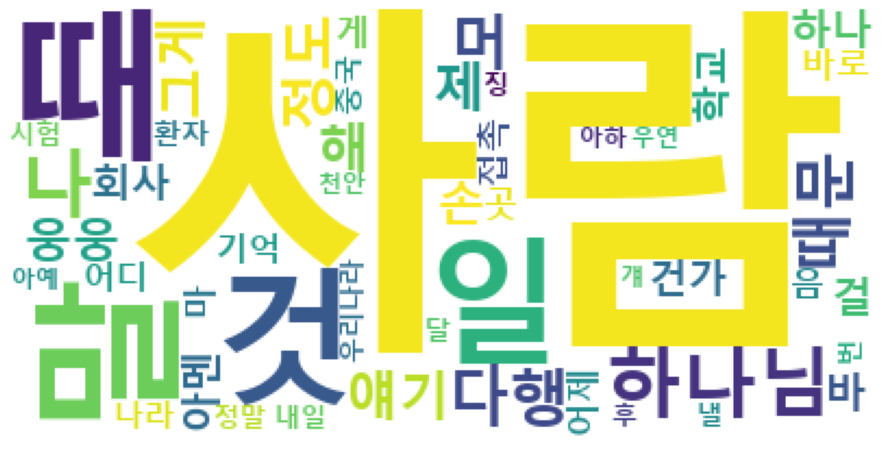

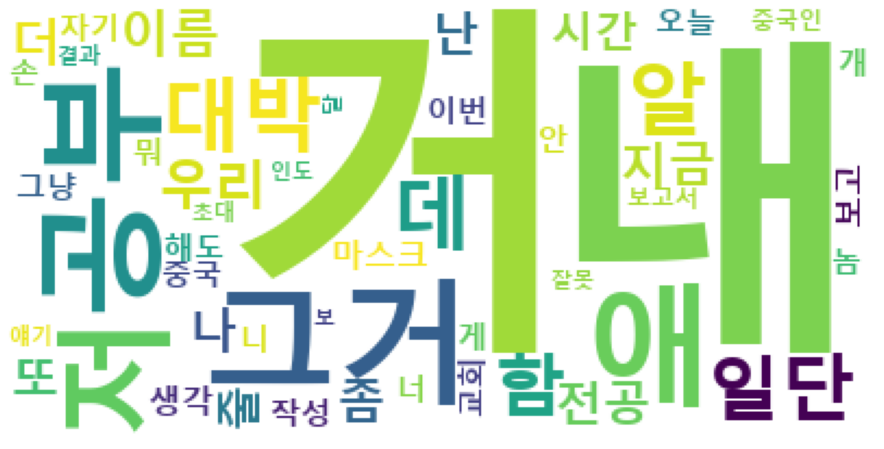

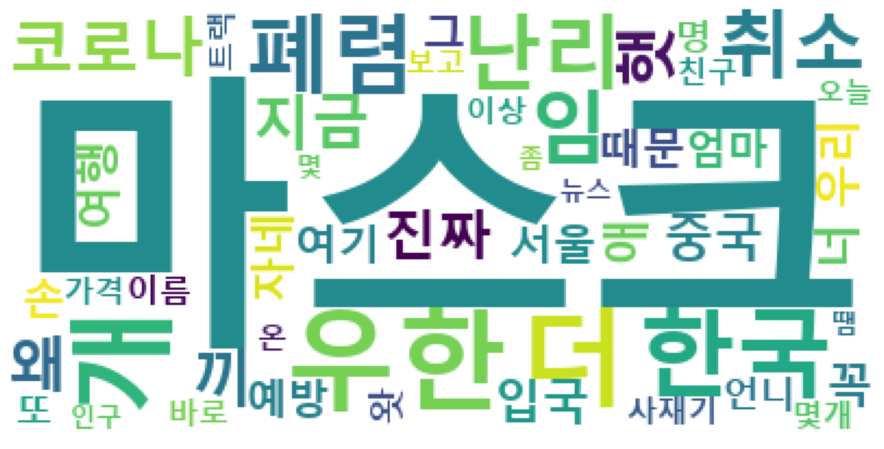

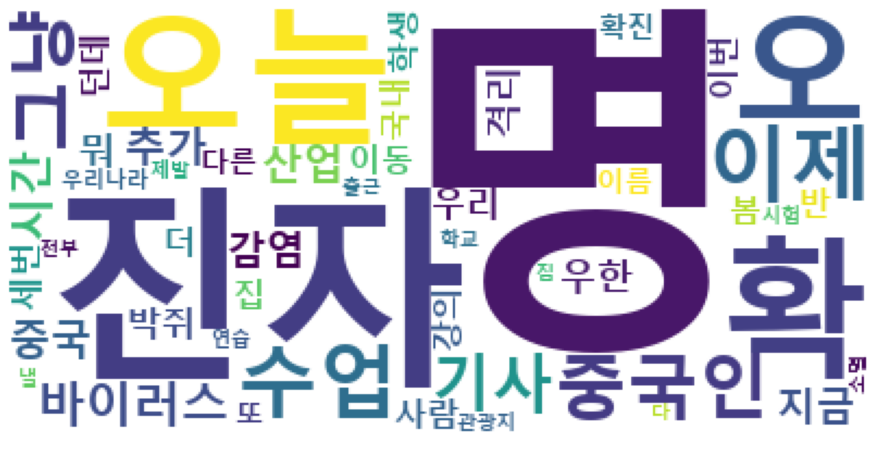

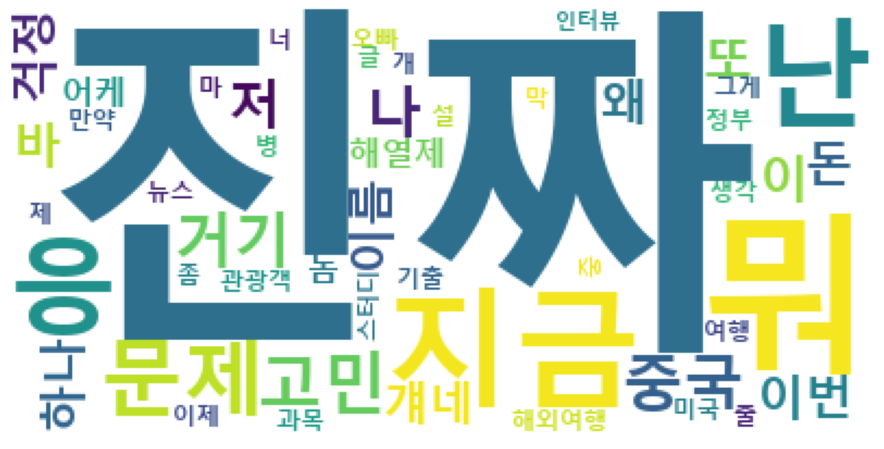

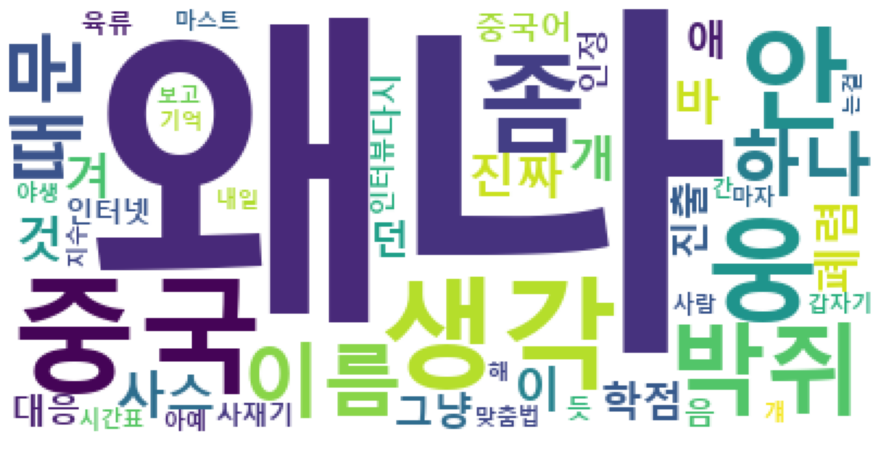

In [43]:
#토픽별 word cloud
def flatten(l):
    flatList=[]
    for elem in l:
        if type(elem) == list:
            for e in elem:
                flatList.append(e)
        else:
            flatList.append(elem)
    return flatList


for i in range(1,topic_num+1):
    data_list = globals()['df_{}'.format(i)].utterance.values.tolist()
    data_word=[]
    
    for j in range(len(data_list)):
        try:
            data_word.append(okt.nouns(data_list[j]))
        except Exception as e:
            continue       
    data_word=flatten(data_word)
    data_word=[x for x in data_word if not x.isdigit()]
    
    freq=pd.Series(data_word).value_counts().head(50)
    freq=dict(freq)
    
    wordcloud = WordCloud(max_font_size=300,
                      font_path='C:\Windows\\Fonts\\malgunbd.ttf',
                      relative_scaling = 0.2,
                     background_color = 'white',
                    ).generate_from_frequencies(freq)
        
   # wordcloud = WordCloud(background_color='white', font_path = font_path).generate_from_frequencies(text) 
    
    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

 #   plt.savefig("./Result/topic("+str(i)+")wordcloud.png")

# 토픽 별 트윗 퍼센트

In [26]:
lda_inform.to_csv ("./Result/lda_inform.csv", index = None)
lda_inform

FileNotFoundError: [Errno 2] No such file or directory: './Result/lda_inform.csv'

In [19]:
#df_topic_tweet.to_csv ("./Result/df_topic_tweet.csv", index = None)
df_topic_tweet

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Timestamp,Tweet_url,Screen_name,label,Clean
0,0,5,0.1164,"일, 감염증, 바이러스, 지금, 시, 월, 우리, 것, 때문, 확산",사스가 아시아에서 출현한 후 세계 보건 기구는 년 월 일 여러 실험실...,2019-12-04,/snowcheck2/status/1202119408283316225,snowcheck2,0,"[사스, 아시아, 출현, 후, 세계, 보건, 기구, 년, 월, 일, 여러, 실험실,..."
1,1,5,0.1183,"일, 감염증, 바이러스, 지금, 시, 월, 우리, 것, 때문, 확산",사스의 원인이 되는 바이러스이다 사스가 아시아에서 출현한 후 세계 보건 기구는 ...,2019-12-12,/snowcheck2/status/1205010308416147456,snowcheck2,0,"[사스, 원인, 바이러스, 사스, 아시아, 출현, 후, 세계, 보건, 기구, 년, ..."
2,2,5,0.1013,"일, 감염증, 바이러스, 지금, 시, 월, 우리, 것, 때문, 확산",내일은 카사코로나에 출동 합니다 링다의 라이브도 보게 되고 짱멋있는 디제이 분들...,2019-12-14,/sukyuel/status/1205849913831120897,sukyuel,1,"[내일, 코로나, 출동, 링다, 라이브, 디제이, 분, 셀렉, 저, 저녁, 시, 분..."
3,3,8,0.1280,"출처, 네이버, 뉴스, 사람, 때문, 블로그, 한국, 것, 이, 걱정",우한 폐렴 사스 아닌 신종 코로나바이러스 잠정 판정 출처 ...,2020-01-09,/lastromancist/status/1215221939062493185,lastromancist,0,"[우한, 폐렴, 사스, 신종, 코로나바이러스, 잠정, 판정, 출처, 네이버, 뉴스]"
4,4,1,0.0994,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",국제 중국의 전염병 위험 증가 추세 신종 코로나바이러스로 추정 ...,2020-01-09,/hmk0697/status/1215196264305840129,hmk0697,0,"[국제, 중국, 전염병, 위험, 증가, 추세, 신종, 코로나바이러스, 추정]"
...,...,...,...,...,...,...,...,...,...,...
559,559,1,0.0991,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",문제인 정부의 신종코로나 대처법 우왕자왕 갈팡질팡 오락가락,2020-02-01,/DooBaeYoung/status/1223417981637513216,DooBaeYoung,0,"[문제, 정부, 신종, 코로나, 대처, 법, 왕자, 갈팡질팡, 오락가락]"
560,560,9,0.1296,"명, 확진, 블로그, 환자, 출처, 걱정, 것, 때문, 우리, 마스크",월 일 오전 시 현재 중국우한페렴 코로나바이러스 확진자 명 사망자...,2020-02-01,/DooBaeYoung/status/1223415559137529856,DooBaeYoung,0,"[월, 일, 오전, 시, 현재, 중국, 우한, 페렴, 코로나바이러스, 확진자, 명,..."
561,561,9,0.1186,"명, 확진, 블로그, 환자, 출처, 걱정, 것, 때문, 우리, 마스크",속보 신종코로나 국내 명추가 총 명,2020-02-01,/DooBaeYoung/status/1223413921073123328,DooBaeYoung,1,"[속보, 신종, 코로나, 국내, 명, 추가, 총, 명]"
562,562,1,0.0833,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",아 제가 이렇게 눈치가 없습니돠 ㅎㅎ 코로나 잠잠해지면 군산 오십시오 ㅎㅎ,2020-02-01,/tmlQZX1owU3sqsb/status/1223403345164943361,tmlQZX1owU3sqsb,1,"[제, 눈치, 없습니돠, 코로나, 군산, 시오]"


# 토픽 별 트윗 저장

In [20]:
#토픽별 트윗 저장
for i in range(1,topic_num+1):
    globals()['df_{}'.format(i)]=df_topic_tweet.loc[df_topic_tweet.Dominant_Topic==str(i)]
    globals()['df_{}'.format(i)].sort_values('Topic_Perc_Contrib',ascending=False,inplace = True)
    globals()['df_{}'.format(i)].to_csv ("./Result/topic("+str(i)+")_tweet.csv", index = None)
    



/root/corona/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [21]:
#df_1~df_?? 토픽 수 까지
df_1

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Timestamp,Tweet_url,Screen_name,label,Clean
408,408,1,0.1580,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",와우 이거 무서워 살겠나 중국 중국 중국 중국몽에 퐁당빠져 헤매던 문쩝쩝이 완전히 ...,2020-01-31,/3CKcZIbFwIfqHhU/status/1223206193373429760,3CKcZIbFwIfqHhU,1,"[와우, 거, 중국, 중국, 중국, 중국몽, 퐁당, 문, 개, 중국, 발, 핵폭탄,..."
549,549,1,0.1535,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",중국행 여행 금지 확산 중국 하늘길 막힌다 미국을 위시해서 세계 곳곳에서...,2020-02-01,/sungodcross/status/1223434684333342721,sungodcross,0,"[중국, 행, 여행, 금지, 확산, 중국, 하늘, 길, 미국, 위시, 세계, 곳곳,..."
166,166,1,0.1441,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",우한 코로나가 극심하다 그런데 이게 사람간 간염이 중요하지만 왜 우한인가의 환경적...,2020-01-28,/NwQCrmfXxzyim05/status/1222148132873486338,NwQCrmfXxzyim05,1,"[우한, 코로나, 이, 사람, 간염, 왜, 우한, 의, 환경, 관심, 래야, 그래프..."
366,366,1,0.1257,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",중국 전역이 신종 코로나바이러스 감염증으로 몸살을 앓는 가운데 한국기업들이 신종 코...,2020-01-31,/estarkkr/status/1223345464432398337,estarkkr,1,"[중국, 전역, 신종, 코로나바이러스, 감염증, 몸살, 가운데, 한국, 기업, 신종..."
311,311,1,0.1257,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",우리나라 지난해 최대 무역흑자국은 홍콩 위 중국 미국 일본 순 ...,2020-01-30,/cjjh7722/status/1222832942264639488,cjjh7722,0,"[우리나라, 지난해, 최대, 무역흑자, 국, 홍콩, 위, 중국, 미국, 일본, 순,..."
...,...,...,...,...,...,...,...,...,...,...
8,8,1,0.0833,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",요즘은 코로나 드시더라 특이해 ㅋㅋㅋ,2020-01-19,/baeryo/status/1218747082846003201,baeryo,0,"[요즘, 코로나]"
332,332,1,0.0833,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",ㅋㅋㅋ잡년둘 코로나 무서워서 새벽에는 안돌아 다니네 ㅋㅋㅋ 미친년,2020-01-30,/td65031/status/1222737042246795264,td65031,0,"[잡년, 둘, 코로나, 새벽, 년]"
345,345,1,0.0833,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",철수의 철수가 죽었다 깨나도 철수에겐 없을 무 공감과 배려양보 ...,2020-01-30,/jckmon/status/1222701257913094144,jckmon,0,"[철수, 철수, 깨나, 철수, 무, 공감, 배려, 양보, 이성, 희생, 헌신, 정치..."
346,346,1,0.0833,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",서 설마 코로나,2020-01-30,/bruiseheart/status/1222701158663241730,bruiseheart,0,"[설마, 코로나]"


# 토픽 별 word cloud

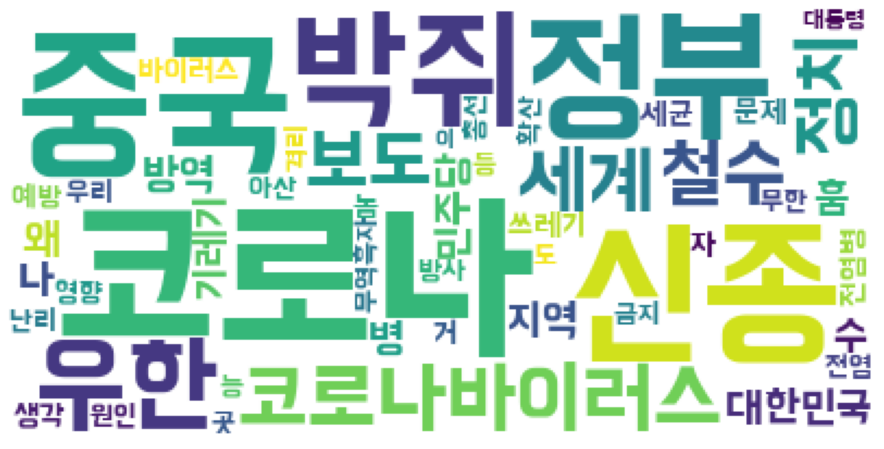

<Figure size 432x288 with 0 Axes>

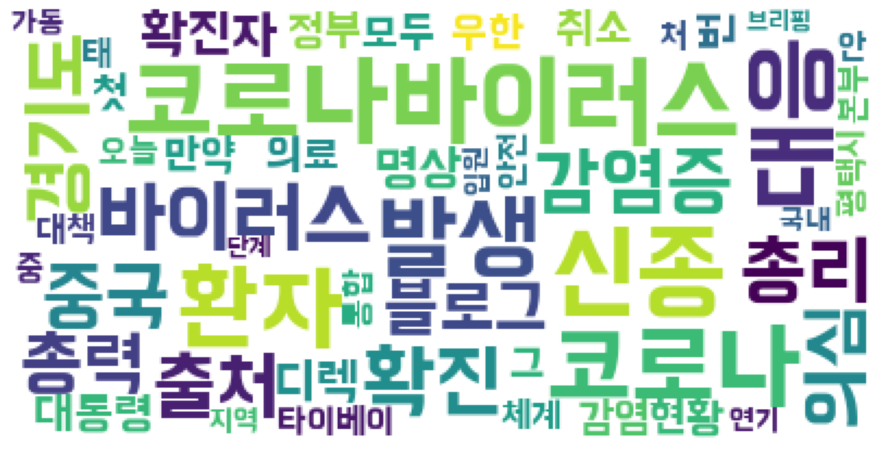

<Figure size 432x288 with 0 Axes>

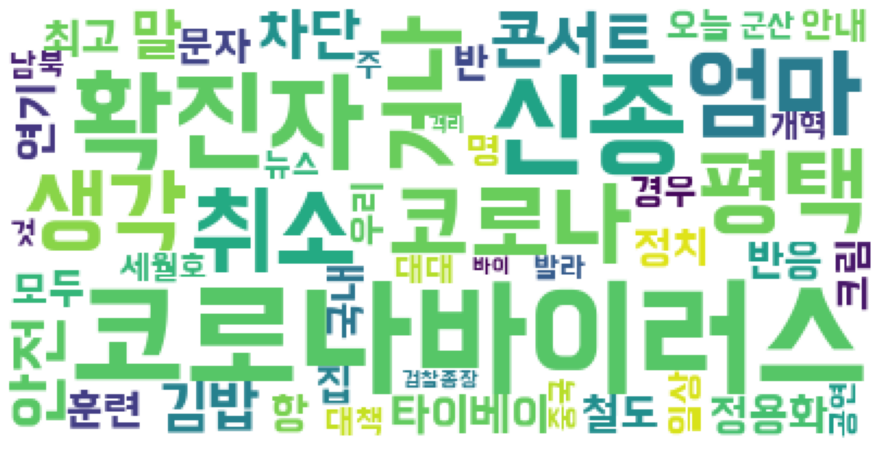

<Figure size 432x288 with 0 Axes>

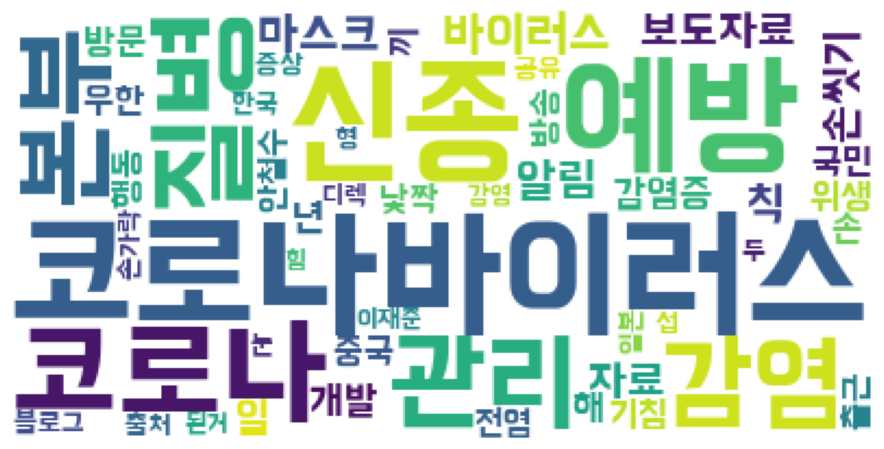

<Figure size 432x288 with 0 Axes>

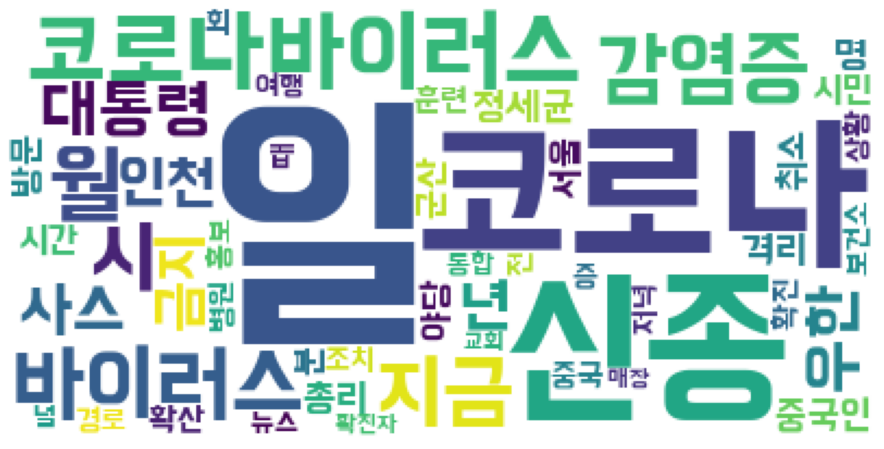

<Figure size 432x288 with 0 Axes>

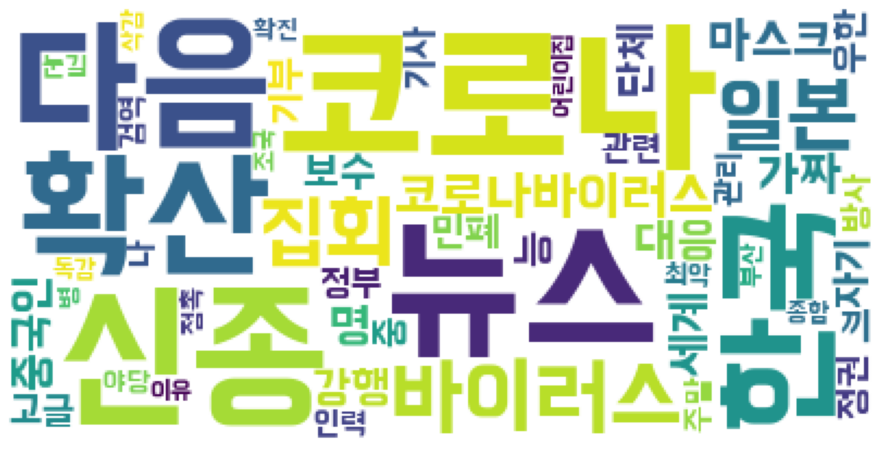

<Figure size 432x288 with 0 Axes>

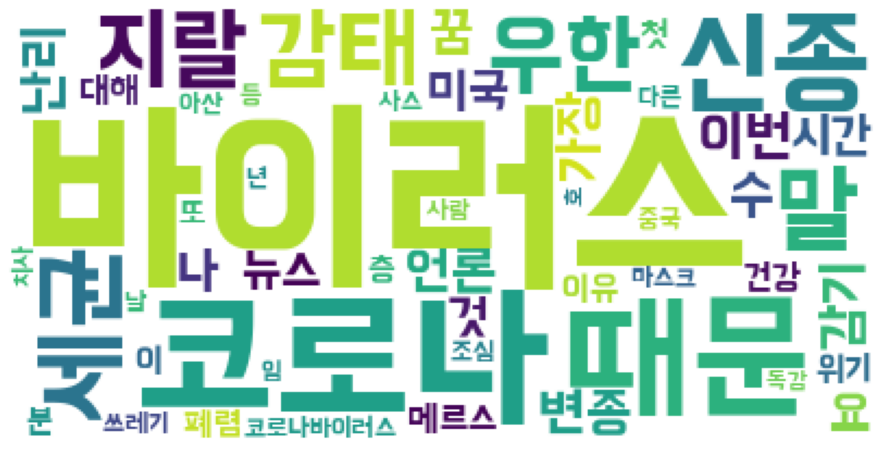

<Figure size 432x288 with 0 Axes>

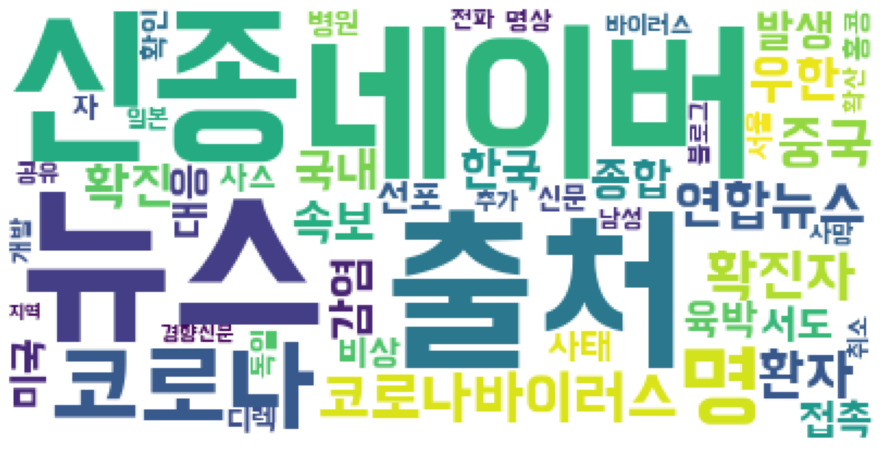

<Figure size 432x288 with 0 Axes>

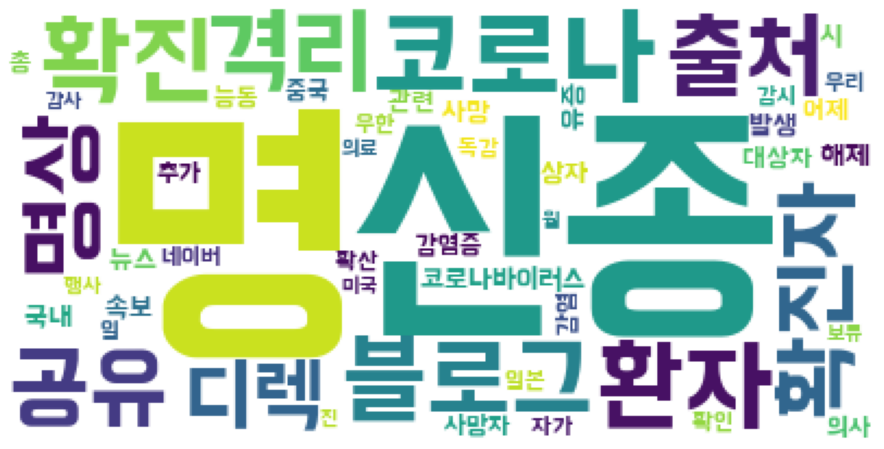

<Figure size 432x288 with 0 Axes>

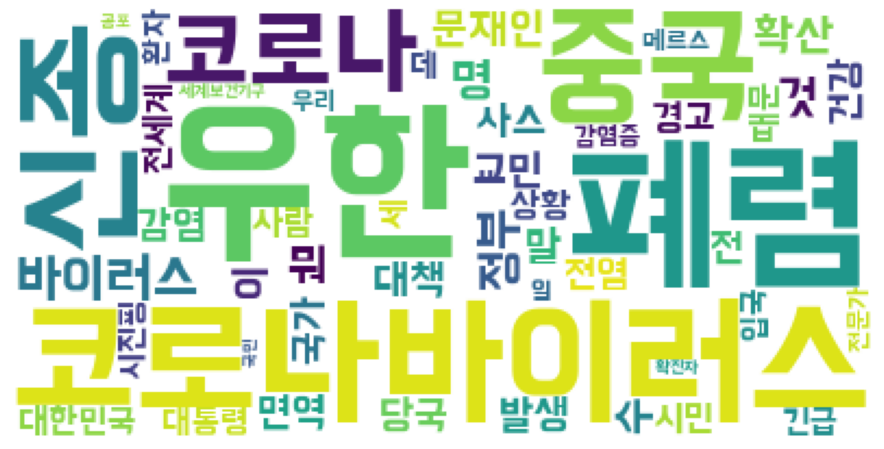

<Figure size 432x288 with 0 Axes>

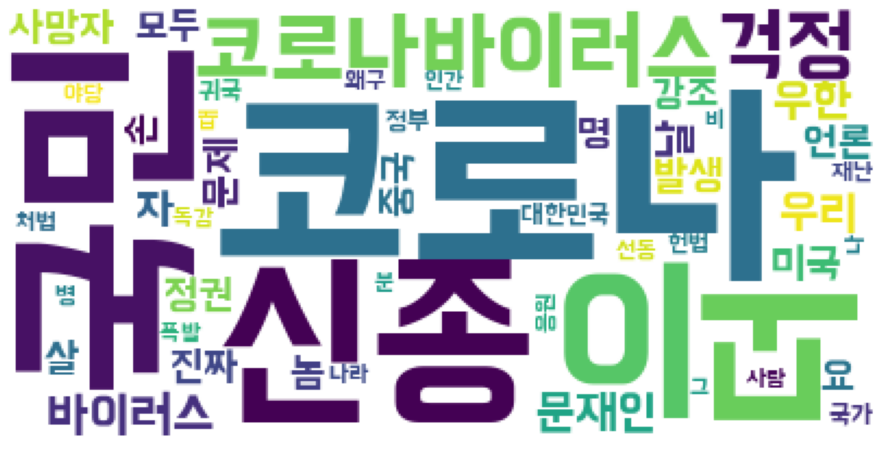

<Figure size 432x288 with 0 Axes>

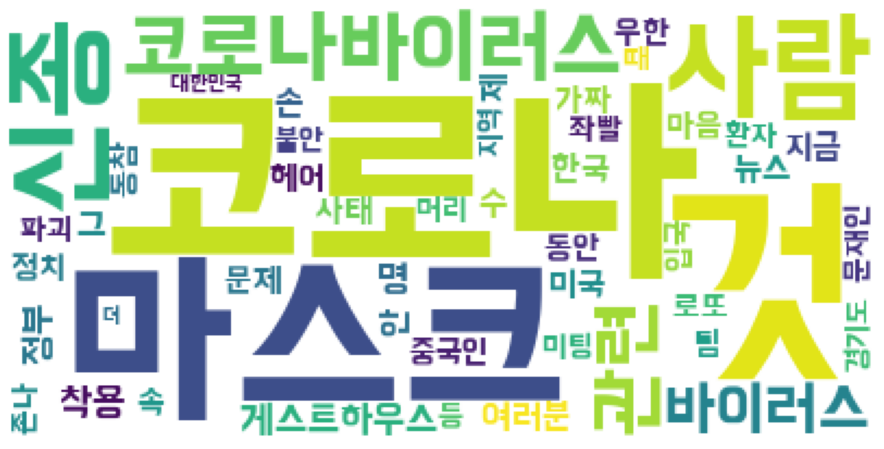

<Figure size 432x288 with 0 Axes>

In [22]:
for i in range(1,topic_num+1):
    #data_list = globals()['df_{}'.format(i)].Text.values.tolist()
    long_string = sum(globals()['df_{}'.format(i)].Clean.values,[])
    str(long_string)
    
    
    
    #data_word=[x for x in data_word if not x.isdigit()]
    
    freq=pd.Series(long_string).value_counts().head(50)
    freq=dict(freq)
    # Create a WordCloud object
    freq=dict(freq)
    
    wordcloud = WordCloud(font_path="./Font/BMHANNA_11yrs_ttf.ttf",
             relative_scaling = 0.2,
             background_color = 'white',
            ).generate_from_frequencies(freq)
    
    # Visualize the word cloud
    wordcloud.to_image()
    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

    plt.savefig("./Result/topic("+str(i)+")wordcloud.png")


# 토픽 별 긍부정 비율

In [23]:

for i in range(1,topic_num+1):
    globals()['df_{}_pn'.format(i)]=globals()['df_{}'.format(i)].label.value_counts(normalize=True) * 100
    globals()['df_{}_pn'.format(i)]
  #  globals()['df_{}_pn'.format(i)].to_csv ("./Result/topic_tweet(topic"+str(i)+")posneg.csv", index = None)
    



In [24]:
#df_1_pn~df_?? 토픽 수 까지
df_1_pn


0    71.604938
1    28.395062
Name: label, dtype: float64

# 토픽 별 긍정 부정 트윗 

In [25]:
for i in range(1, topic_num+1):
    globals()['df_{}_positive'.format(i)]=globals()['df_{}'.format(i)][globals()['df_{}'.format(i)]['label'] == 1]
    globals()['df_{}_negative'.format(i)]=globals()['df_{}'.format(i)][globals()['df_{}'.format(i)]['label'] == 0]
    globals()['df_{}_positive'.format(i)].to_csv ("./Result/topic("+str(i)+")_tweet_positive.csv", index = None)
    globals()['df_{}_negative'.format(i)].to_csv ("./Result/topic("+str(i)+")_tweet_negative.csv", index = None)

In [26]:
df_1_positive

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Timestamp,Tweet_url,Screen_name,label,Clean
408,408,1,0.1580,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",와우 이거 무서워 살겠나 중국 중국 중국 중국몽에 퐁당빠져 헤매던 문쩝쩝이 완전히 ...,2020-01-31,/3CKcZIbFwIfqHhU/status/1223206193373429760,3CKcZIbFwIfqHhU,1,"[와우, 거, 중국, 중국, 중국, 중국몽, 퐁당, 문, 개, 중국, 발, 핵폭탄,..."
166,166,1,0.1441,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",우한 코로나가 극심하다 그런데 이게 사람간 간염이 중요하지만 왜 우한인가의 환경적...,2020-01-28,/NwQCrmfXxzyim05/status/1222148132873486338,NwQCrmfXxzyim05,1,"[우한, 코로나, 이, 사람, 간염, 왜, 우한, 의, 환경, 관심, 래야, 그래프..."
366,366,1,0.1257,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",중국 전역이 신종 코로나바이러스 감염증으로 몸살을 앓는 가운데 한국기업들이 신종 코...,2020-01-31,/estarkkr/status/1223345464432398337,estarkkr,1,"[중국, 전역, 신종, 코로나바이러스, 감염증, 몸살, 가운데, 한국, 기업, 신종..."
179,179,1,0.1101,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",전염병 예방을 위해서 수고하시는 모든 분들께 경의를 표합니다 중국인민들도 잘...,2020-01-28,/kscmylife35/status/1222106835991138304,kscmylife35,1,"[전염병, 예방, 위해, 수고, 모든, 분, 경의, 표, 중국, 인민, 내기, 우리..."
328,328,1,0.1013,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",민주당아 당신들이 그런 상투적 워딩 안해도 정부에서 격리 건물이나 지역은 ...,2020-01-30,/bylee200/status/1222777811108151296,bylee200,1,"[민주당, 당신, 상투, 워딩, 안해, 정부, 격리, 건물, 지역, 신종, 코로나,..."
350,350,1,0.0994,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",종편등 기레기놈들의 호들갑과 불안감 조성이 악영향을 끼쳤다고 봅니다만 지역 이기...,2020-01-30,/bylee200/status/1222692341976190981,bylee200,1,"[종편, 등, 기레기, 놈, 호들갑, 불안감, 조성, 악, 영향, 지역, 이기주의,..."
304,304,1,0.0975,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",우한이 한문으로는 무사무 한나라한 무한이며 중국 중부서 인구가 가장 많은 곳이며 장...,2020-01-30,/td65031/status/1222881842497376257,td65031,1,"[우한, 한문, 무사, 무, 한나라, 무한, 중국, 중부, 인구, 가장, 곳, 장강..."
24,24,1,0.0957,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",중국 우한 코로나 국내 첫 확진 감염경보 주의 상향 ...,2020-01-20,/lastromancist/status/1219229880522379264,lastromancist,1,"[중국, 우한, 코로나, 국내, 첫, 확진, 감염, 경보, 주의, 상향]"
390,390,1,0.0833,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",심금라이브 신종코로나 특집,2020-01-31,/thousandgru/status/1223246287601946624,thousandgru,1,"[심금, 라이브, 신종, 코로나, 특집]"
542,542,1,0.0833,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",신종코로나 완치후에도 재감 염될수있다 클났네 ㅠㅠ ...,2020-02-01,/challenger21c/status/1223471997482455040,challenger21c,1,"[신종, 코로나, 완치, 후, 재감, 염]"


In [27]:
df_1_negative

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Timestamp,Tweet_url,Screen_name,label,Clean
549,549,1,0.1535,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",중국행 여행 금지 확산 중국 하늘길 막힌다 미국을 위시해서 세계 곳곳에서...,2020-02-01,/sungodcross/status/1223434684333342721,sungodcross,0,"[중국, 행, 여행, 금지, 확산, 중국, 하늘, 길, 미국, 위시, 세계, 곳곳,..."
311,311,1,0.1257,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",우리나라 지난해 최대 무역흑자국은 홍콩 위 중국 미국 일본 순 ...,2020-01-30,/cjjh7722/status/1222832942264639488,cjjh7722,0,"[우리나라, 지난해, 최대, 무역흑자, 국, 홍콩, 위, 중국, 미국, 일본, 순,..."
534,534,1,0.1142,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",중국사람들 대한민국 입국을 막아야한다 또한 입국한 중국인들 존국으로 조속히보내야한다...,2020-02-01,/gobumsukk/status/1223512656889335808,gobumsukk,0,"[중국사람, 대한민국, 입국, 또한, 입국, 중국, 존국, 조속, 조치, 걸, 프로..."
456,456,1,0.1101,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",코로나바이러스 원인은 박쥐 유래설 중국 사람들이 박쥐를 먹는 이유 박쥐의 중...,2020-01-31,/leesk0104/status/1223073619242180609,leesk0104,0,"[코로나바이러스, 원인, 박쥐, 유래, 설, 중국, 사람, 박쥐, 이유, 박쥐, 중..."
474,474,1,0.1101,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",코로나 바이러스가 창궐하는 우한에서 멀지않은 후난성에서 조류독감이 발생했다고 중국이...,2020-02-01,/kdchoi51/status/1223742030490136576,kdchoi51,0,"[코로나, 바이러스, 창궐, 우한, 후난성, 조류독감, 발생, 중국, 보도, 설상가..."
206,206,1,0.1082,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",신종 코로나바이러스 감염증 예방수칙 대중교통 공공장소 마스크 착용 비누로 꼼꼼하게 ...,2020-01-28,/guricitynews/status/1222026395909419009,guricitynews,0,"[신종, 코로나바이러스, 감염증, 예방, 칙, 대중교통, 공공장소, 마스크, 착용,..."
537,537,1,0.1063,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",요즘 트위터에도 번 무자게 많음 민주당 짱깨들 ㅉㅉ 자국민 마스크 뺏어 ...,2020-02-01,/YbLnl054vEUlML3/status/1223496561298042880,YbLnl054vEUlML3,0,"[요즘, 트위터, 번, 무자, 민주당, 짱깨, 자, 국민, 마스크, 중국, 조공, ..."
42,42,1,0.1060,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",신종 코로나 갈수록 확산 중국당국 초기대응 실패 심각합니다 신종코로나 우한...,2020-01-22,/beeyoil/status/1219904717544779777,beeyoil,0,"[신종, 코로나, 갈수록, 확산, 중국, 당국, 초기, 대응, 실패, 신종, 코로나..."
224,224,1,0.1019,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",신종코로나 다행히 치사율이 최고는 아니나 전염성이 근래에 가장높은게 범국가적인...,2020-01-29,/bylee200/status/1222607089442275328,bylee200,0,"[신종, 코로나, 치사, 율, 최고, 전염, 근래, 가장, 범, 국가, 대응, 상황..."
280,280,1,0.1013,"중국, 정부, 대응, 사람, 때문, 마스크, 한국, 확산, 블로그, 것",쓰레기 조중동은 신종코로나를 가지고 정부를 비꼬고 필요이상으로 두려움을 조장하지...,2020-01-29,/tksRnfjrl46/status/1222344501781397504,tksRnfjrl46,0,"[쓰레기, 조중동, 신종, 코로나, 가지, 정부, 필요, 이상, 두려움, 조장, 낼..."


In [28]:
Data= pd.read_csv('./KOREA_Tweet_Data.csv', encoding="utf-8")